In [65]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [31]:
SIGNIFICANT_P = 0.05
def test_stationarity(data):
    # AIC - autolag parameter which automates
    # the selection of the lag length based on information criteria and penalises complex models.

    # ct - ct: It stands for "constant and trend."
    # The regression model includes both a constant (intercept) and a linear trend term.
    # H0: data is not stationary
    result = adfuller(data, autolag="AIC")#maxlag=maxlag, regression='ct')

    isStationary = False
    if (
        # result[0] < result[4]["1%"] and  and result[0] < result[4]["10%"]\
        result[0] < result[4]["5%"] and result[1] < SIGNIFICANT_P):
        isStationary = True
    else:
        isStationary = False
    
    return { "stationarity": result, "isStationary": isStationary }

In [54]:
def convert_data_to_stationary(df):
    # how to deal with non linear non stationarity?
    # put an upper limit on the order
    df_diff = df.copy()
    diff_order = 0
    is_stationary = False
    diffs = [df_diff]
    while is_stationary == False:
        for i in range(len(df_diff.columns)):

            stationarityTestResult = test_stationarity(df_diff[df_diff.columns[i]])
            is_stationary = stationarityTestResult["isStationary"]
            print('Column {0} stationarity: {1}'.format(df_diff.columns[i], is_stationary))
            if is_stationary == False:
                print('False')
                break
        if is_stationary == False:
            print("is_stationary -> {0}, differenced {1} times".format(is_stationary, diff_order))
            diff_order += 1
            # Apply differencing to make data stationary
            df_diff = df_diff.copy().diff().dropna()
            diffs.append(df_diff)
        print(f"Diff order: {diff_order}")
        df_diff.plot()
        plt.show()
    return df_diff, diff_order, diffs

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [9]:
data = pd.read_csv('./test_data/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
data.shape


(144, 2)

In [11]:
data.columns


Index(['Month', '#Passengers'], dtype='object')

In [12]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [14]:
data.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [15]:
data.describe()


,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [16]:
data['Date'] = pd.to_datetime(data["Month"])
data = data.drop(columns=['Month'])

In [17]:
data = data.set_index('Date')
data = data.rename(columns={ '#Passengers': 'Passengers' })
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Date'>

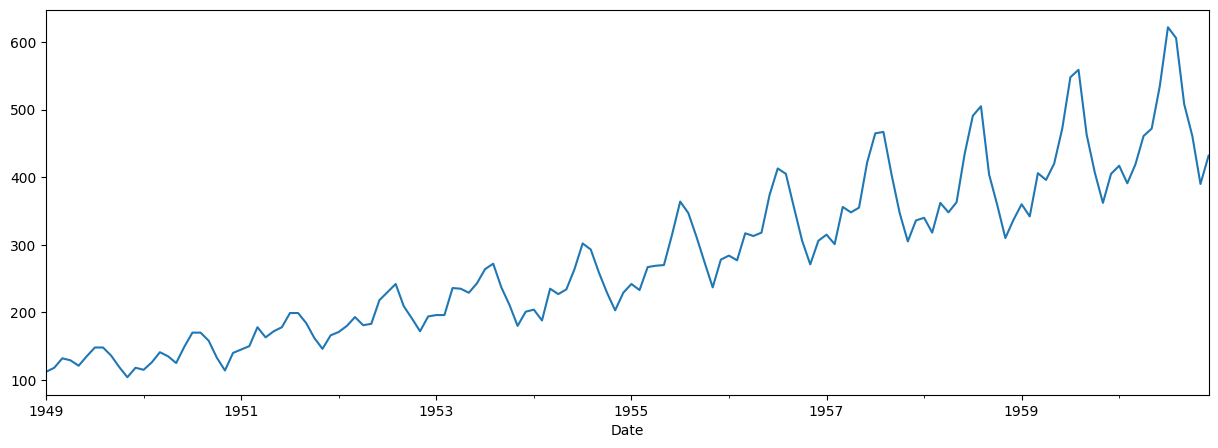

In [18]:
plt.figure(figsize=(15,5))
data['Passengers'].plot()

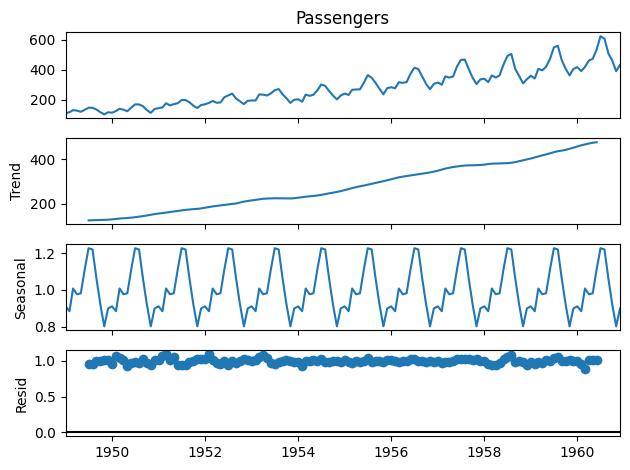

In [39]:
# model multiplicative - ?
decomposed = sm.tsa.seasonal_decompose(data["Passengers"], period=12, model="multiplicative").plot()

In [33]:
test_stationarity(data['Passengers'])

{'stationarity': (0.8153688792060447,
  0.9918802434376409,
  13,
  130,
  {'1%': -3.4816817173418295,
   '5%': -2.8840418343195267,
   '10%': -2.578770059171598},
  996.692930839019),
 'isStationary': False}

Column Passengers stationarity: False
False
is_stationary -> False, differenced 0 times
Diff order: 1


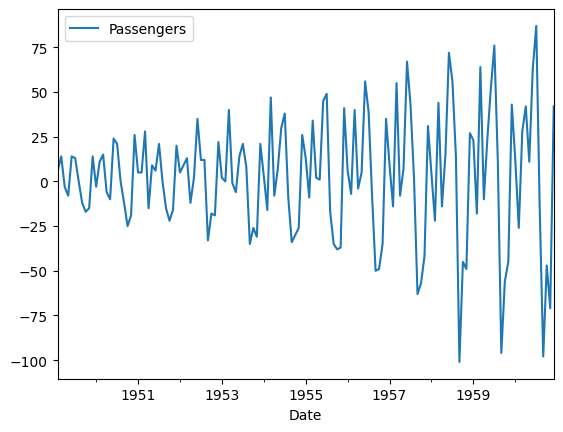

Column Passengers stationarity: False
False
is_stationary -> False, differenced 1 times
Diff order: 2


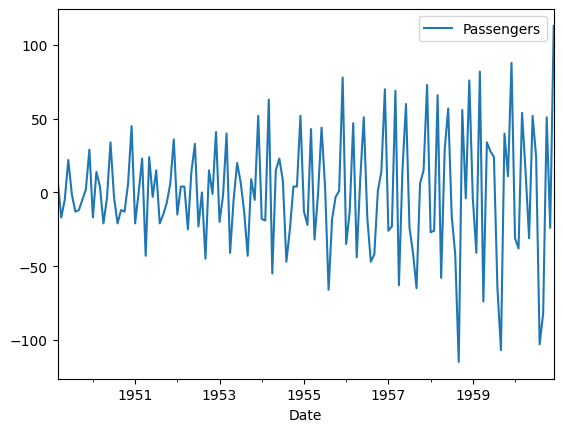

Column Passengers stationarity: True
Diff order: 2


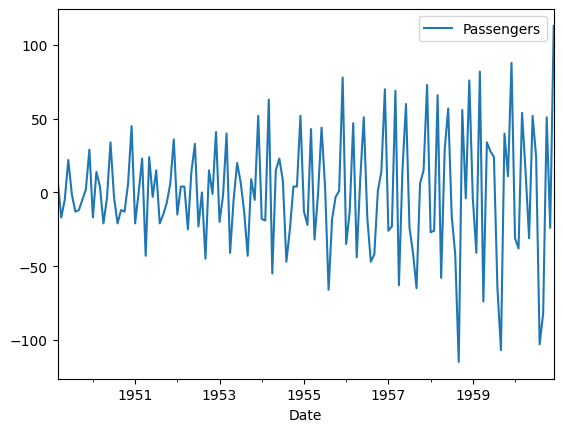

In [60]:
data_last_diff, diff_order, data_diffs = convert_data_to_stationary(data)

In [57]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


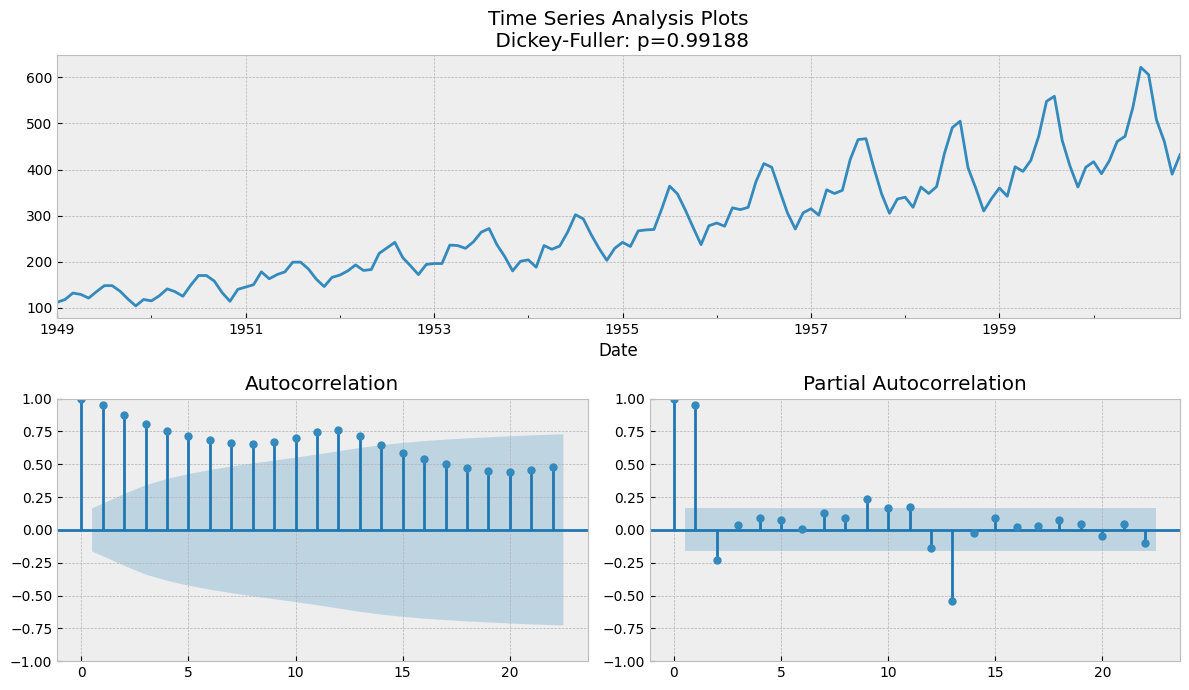

In [58]:
tsplot(data['Passengers'])


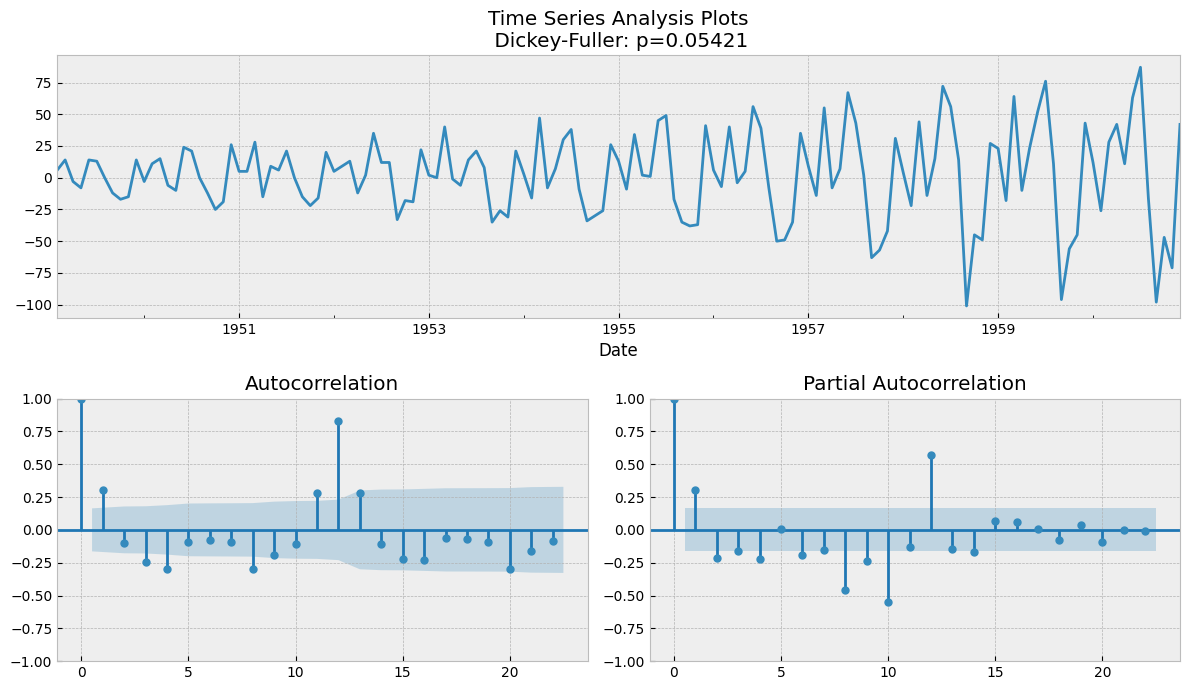

In [61]:
data_diff = data_diffs[1]
tsplot(data_diff['Passengers'])


In [67]:
# p = 2 - related to lag order
# d = 1 - related to the differencing order
# q = 2 - related to the moving average order
model = ARIMA(data['Passengers'], order=(2, 1, 2))
model_fit = model.fit()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Fri, 22 Mar 2024   AIC                           1353.347
Time:                        11:54:54   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.831      0.0

In [97]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 435.368729, expected = 491.000000
predicted = 487.825559, expected = 505.000000
predicted = 484.761914, expected = 404.000000
predicted = 359.074739, expected = 359.000000
predicted = 380.902398, expected = 310.000000
predicted = 291.231477, expected = 337.000000
predicted = 336.938549, expected = 360.000000
predicted = 367.621040, expected = 342.000000
predicted = 360.295270, expected = 406.000000
predicted = 414.083702, expected = 396.000000
predicted = 378.520878, expected = 420.000000


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 424.478083, expected = 472.000000
predicted = 459.477027, expected = 548.000000
predicted = 534.244222, expected = 559.000000
predicted = 523.511985, expected = 463.000000
predicted = 417.609257, expected = 407.000000
predicted = 366.683799, expected = 362.000000


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 339.217686, expected = 405.000000
predicted = 411.312454, expected = 417.000000
predicted = 435.937921, expected = 391.000000
predicted = 418.796168, expected = 419.000000
predicted = 451.314939, expected = 461.000000
predicted = 488.384072, expected = 472.000000
predicted = 488.569078, expected = 535.000000
predicted = 532.219018, expected = 622.000000


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 601.235270, expected = 606.000000
predicted = 562.885506, expected = 508.000000


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 452.852697, expected = 461.000000
predicted = 415.005593, expected = 390.000000
predicted = 367.684866, expected = 432.000000


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


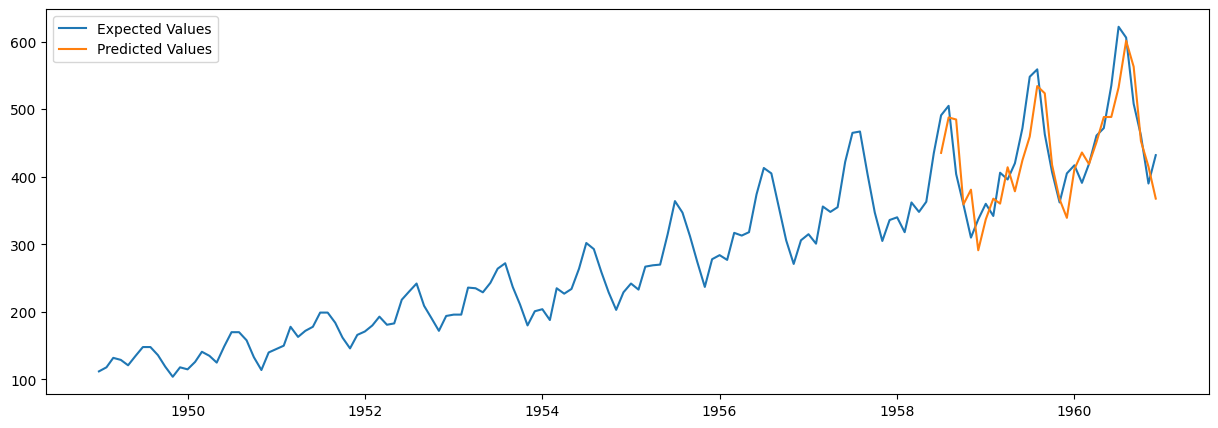

In [98]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [104]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 45.3445


In [100]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


In [101]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    print(output)
    
    ARIMA_history_f.append(output[0])
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[144 + i,1] = f1[i]
forecast.tail(50)

[435.36872883]
[413.3553729]
[407.30914688]
[400.09151696]
[396.5653348]
[393.76538383]
[392.1017937]
[390.93155058]
[390.18895851]
[389.68568659]
[389.36014907]
[389.14045107]
[388.99787111]
[388.90135304]
[388.83906058]
[388.79628838]
[388.76908884]
[388.74985339]
[388.73758672]
[388.72878199]
[388.72383195]
[388.71975664]
[388.71753569]
[388.71553839]
[388.7145503]
[388.71349333]
[388.7130466]
[388.71245261]
[388.712248]
[388.71188829]
[388.71179254]
[388.71155992]
[388.71151449]
[388.71135373]
[388.71133029]
[388.71121852]
[388.71120655]
[388.7111264]
[388.7111202]
[388.7110614]
[388.71105811]
[388.71101433]
[388.71101262]
[388.71098028]
[388.71097946]
[388.71095397]
[388.71095315]
[388.71093446]


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1960-11-01,390,NaN,NaN
1960-12-01,432,NaN,NaN
1960-12-08,NaN,435.37,NaN
1960-12-15,NaN,413.36,NaN
1960-12-22,NaN,407.31,NaN
1960-12-29,NaN,400.09,NaN
1961-01-05,NaN,396.57,NaN
1961-01-12,NaN,393.77,NaN
1961-01-19,NaN,392.10,NaN
1961-01-26,NaN,390.93,NaN


<Axes: >

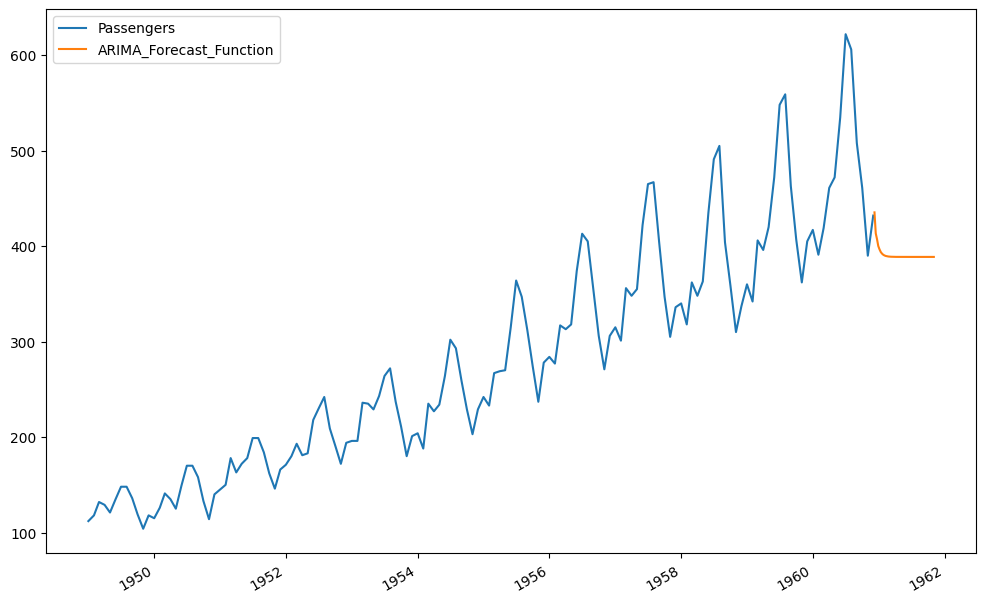

In [103]:
forecast[['Passengers','ARIMA_Forecast_Function']].plot(figsize = (12,8))


In [108]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[144 + i,2] = f2[i]
forecast.tail()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,388.71,388.71
1961-10-12,NaN,388.71,388.71
1961-10-19,NaN,388.71,388.71
1961-10-26,NaN,388.71,388.71
1961-11-02,NaN,388.71,388.71


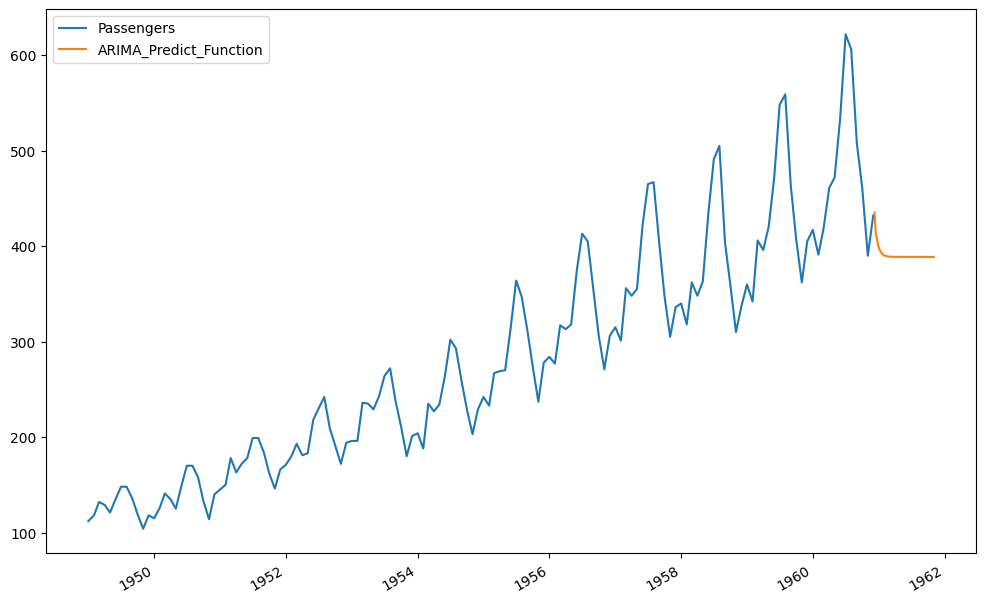

In [109]:
forecast[['Passengers','ARIMA_Predict_Function']].plot(figsize = (12,8));


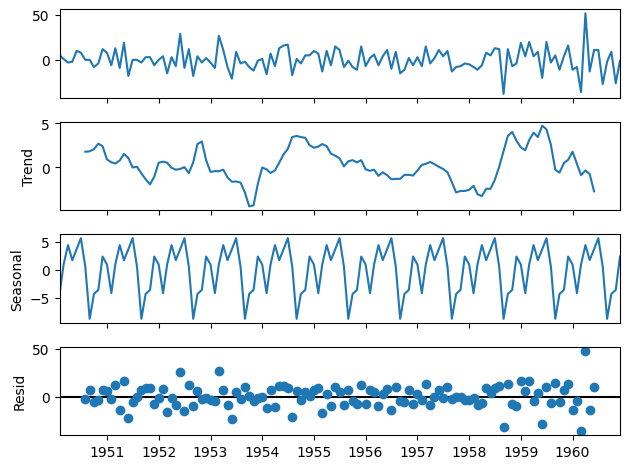

In [110]:
# M = 12 - periodicity, periods to shift for calculating difference
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()


In [111]:
test_stationarity(data_diff_seas['Passengers'])


{'stationarity': (-15.59561808374634,
  1.856511600123444e-28,
  0,
  130,
  {'1%': -3.4816817173418295,
   '5%': -2.8840418343195267,
   '10%': -2.578770059171598},
  919.8428088960275),
 'isStationary': True}

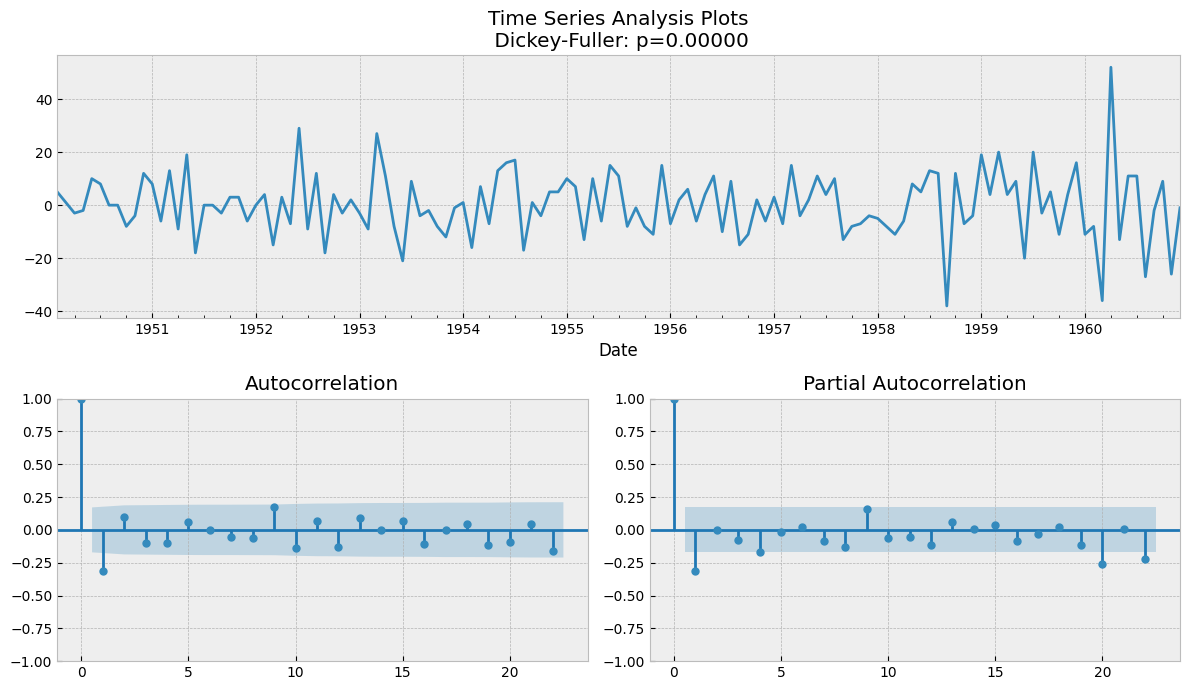

In [112]:
tsplot(data_diff_seas['Passengers'])


In [113]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52286D+00    |proj g|=  8.40730D-02

At iterate    5    f=  3.51094D+00    |proj g|=  1.10231D-02

At iterate   10    f=  3.50236D+00    |proj g|=  2.04172D-02

At iterate   15    f=  3.50094D+00    |proj g|=  7.95686D-03

At iterate   20    f=  3.49979D+00    |proj g|=  1.10264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   2.602D-05   3.500D+00
  F =   3.4997746156044105     

CONVERG

In [114]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24773D+00    |proj g|=  3.85280D-02


 This problem is unconstrained.



At iterate    5    f=  3.24330D+00    |proj g|=  3.92157D-02

At iterate   10    f=  3.23721D+00    |proj g|=  1.66594D-02

At iterate   15    f=  3.22917D+00    |proj g|=  4.75928D-03

At iterate   20    f=  3.22880D+00    |proj g|=  1.37446D-03

At iterate   25    f=  3.22866D+00    |proj g|=  3.95146D-04

At iterate   30    f=  3.22865D+00    |proj g|=  1.69603D-04

At iterate   35    f=  3.22864D+00    |proj g|=  3.39559D-05

At iterate   40    f=  3.22864D+00    |proj g|=  1.69853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     45      1     0     0   3.199D-05   3.229D+00
  F =   3.22864379426

 This problem is unconstrained.



At iterate    5    f=  3.25042D+00    |proj g|=  5.70548D-02

At iterate   10    f=  3.24273D+00    |proj g|=  1.48299D-02

At iterate   15    f=  3.23498D+00    |proj g|=  6.62059D-03

At iterate   20    f=  3.23476D+00    |proj g|=  5.43467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   4.493D-06   3.235D+00
  F =   3.2347276386667239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 490.553509, expected = 505.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.26327D+00    |proj g|=  4.00261D-02

At iterate   10    f=  3.25422D+00    |proj g|=  1.27227D-02

At iterate   15    f=  3.24525D+00    |proj g|=  2.70681D-02

At iterate   20    f=  3.24404D+00    |proj g|=  1.79272D-03

At iterate   25    f=  3.24403D+00    |proj g|=  6.74851D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   6.749D-06   3.244D+00
  F =   3.2440327648833640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 441.276125, expected = 404.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate    5    f=  3.31370D+00    |proj g|=  2.79656D-02

At iterate   10    f=  3.31000D+00    |proj g|=  1.18133D-02

At iterate   15    f=  3.30761D+00    |proj g|=  3.88525D-03

At iterate   20    f=  3.30582D+00    |proj g|=  9.57809D-04

At iterate   25    f=  3.30573D+00    |proj g|=  6.14050D-04

At iterate   30    f=  3.30569D+00    |proj g|=  9.22546D-04

At iterate   35    f=  3.30568D+00    |proj g|=  3.19581D-04

At iterate   40    f=  3.30568D+00    |proj g|=  1.34403D-04

At iterate   45    f=  3.30568D+00    |proj g|=  6.93481D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     60   

 This problem is unconstrained.



At iterate    5    f=  3.31336D+00    |proj g|=  2.65423D-02

At iterate   10    f=  3.30939D+00    |proj g|=  1.00603D-02

At iterate   15    f=  3.30645D+00    |proj g|=  2.42365D-02

At iterate   20    f=  3.30511D+00    |proj g|=  1.19751D-03

At iterate   25    f=  3.30499D+00    |proj g|=  2.67914D-04

At iterate   30    f=  3.30498D+00    |proj g|=  8.97210D-05

At iterate   35    f=  3.30497D+00    |proj g|=  1.66461D-04

At iterate   40    f=  3.30497D+00    |proj g|=  3.01789D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     53      1     0     0   3.648D-05   3.305D+00
  F =   3.30497371561

 This problem is unconstrained.



At iterate    5    f=  3.31337D+00    |proj g|=  2.30939D-02

At iterate   10    f=  3.31018D+00    |proj g|=  9.54707D-03

At iterate   15    f=  3.30732D+00    |proj g|=  2.13204D-02

At iterate   20    f=  3.30545D+00    |proj g|=  1.17640D-03

At iterate   25    f=  3.30526D+00    |proj g|=  2.46767D-04

At iterate   30    f=  3.30523D+00    |proj g|=  6.15047D-04

At iterate   35    f=  3.30523D+00    |proj g|=  2.35603D-04

At iterate   40    f=  3.30523D+00    |proj g|=  2.36092D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     52      1     0     0   7.177D-05   3.305D+00
  F =   3.30522930279

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32397D+00    |proj g|=  5.66356D-02

At iterate    5    f=  3.31603D+00    |proj g|=  2.12585D-02

At iterate   10    f=  3.31441D+00    |proj g|=  8.03693D-03

At iterate   15    f=  3.31311D+00    |proj g|=  4.06487D-03

At iterate   20    f=  3.30985D+00    |proj g|=  1.38417D-02

At iterate   25    f=  3.30945D+00    |proj g|=  2.61614D-03

At iterate   30    f=  3.30919D+00    |proj g|=  1.40734D-03

At iterate   35    f=  3.30915D+00    |proj g|=  1.46874D-03

At iterate   40    f=  3.30914D+00    |proj g|=  4.79418D-04

At iterate   45    f=  3.30914D+00    |proj g|=  1.38100D-04


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.30914D+00    |proj g|=  4.69758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53      1     0     0   4.698D-05   3.309D+00
  F =   3.3091402644480068     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
predicted = 344.250349, expected = 360.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34058D+00    |proj g|=  7.96463D-02

At iterate    5    f=  3.32800D+00    |proj g|=  3.48141D-02

At iterate   10    f=  

 This problem is unconstrained.



At iterate    5    f=  3.32663D+00    |proj g|=  4.40841D-02

At iterate   10    f=  3.32268D+00    |proj g|=  1.39405D-02

At iterate   15    f=  3.31988D+00    |proj g|=  1.22436D-02

At iterate   20    f=  3.31871D+00    |proj g|=  1.57392D-03

At iterate   25    f=  3.31847D+00    |proj g|=  1.49618D-03

At iterate   30    f=  3.31844D+00    |proj g|=  3.30431D-04

At iterate   35    f=  3.31843D+00    |proj g|=  7.33120D-05

At iterate   40    f=  3.31843D+00    |proj g|=  9.57061D-05

At iterate   45    f=  3.31843D+00    |proj g|=  2.89281D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     52   

 This problem is unconstrained.



At iterate    5    f=  3.34160D+00    |proj g|=  2.46573D-02

At iterate   10    f=  3.33508D+00    |proj g|=  2.03408D-02

At iterate   15    f=  3.33266D+00    |proj g|=  8.60905D-03

At iterate   20    f=  3.33136D+00    |proj g|=  4.13702D-03

At iterate   25    f=  3.33130D+00    |proj g|=  2.04723D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   2.378D-05   3.331D+00
  F =   3.3313041075542884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 387.333486, expected = 396.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.


At iterate    5    f=  3.34487D+00    |proj g|=  2.28446D-02

At iterate   10    f=  3.34258D+00    |proj g|=  9.77844D-03

At iterate   15    f=  3.33359D+00    |proj g|=  1.37306D-02

At iterate   20    f=  3.33333D+00    |proj g|=  7.01925D-04

At iterate   25    f=  3.33329D+00    |proj g|=  4.95350D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   1.572D-06   3.333D+00
  F =   3.3332856211930304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 408.192790, expected = 420.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.2

 This problem is unconstrained.



At iterate   10    f=  3.35345D+00    |proj g|=  3.36737D-02

At iterate   15    f=  3.34186D+00    |proj g|=  1.75661D-02

At iterate   20    f=  3.33791D+00    |proj g|=  4.15478D-03

At iterate   25    f=  3.33786D+00    |proj g|=  2.73648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     35      1     0     0   2.949D-05   3.338D+00
  F =   3.3378496274098528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 485.988940, expected = 472.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate   10    f=  3.34812D+00    |proj g|=  1.56471D-02

At iterate   15    f=  3.34559D+00    |proj g|=  5.86434D-03

At iterate   20    f=  3.34446D+00    |proj g|=  1.64756D-03

At iterate   25    f=  3.34443D+00    |proj g|=  1.56415D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   1.059D-05   3.344D+00
  F =   3.3444305559143461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 529.031343, expected = 548.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.36871D+00    |proj g|=  1.00986D-02

At iterate   10    f=  3.35901D+00    |proj g|=  2.45576D-02

At iterate   15    f=  3.35728D+00    |proj g|=  3.39659D-03

At iterate   20    f=  3.35671D+00    |proj g|=  2.87672D-03

At iterate   25    f=  3.35669D+00    |proj g|=  2.99063D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   2.991D-06   3.357D+00
  F =   3.3566898480250797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 551.914005, expected = 559.000000
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37926D+00    |proj g|=  5.99427D-02

At iterate    5    f=  3.37116D+00    |proj g|=  2.01381D-02

At iterate   10    f=  3.36311D+00    |proj g|=  3.58865D-02

At iterate   15    f=  3.35819D+00    |proj g|=  1.24547D-02

At iterate   20    f=  3.35752D+00    |proj g|=  3.52540D-03

At iterate   25    f=  3.35750D+00    |proj g|=  3.28650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     33      1     0     0   1.696D-05   3.357D+00
  F 

 This problem is unconstrained.



At iterate    5    f=  3.37206D+00    |proj g|=  2.90376D-02

At iterate   10    f=  3.36563D+00    |proj g|=  3.19642D-02

At iterate   15    f=  3.35788D+00    |proj g|=  9.04210D-03

At iterate   20    f=  3.35702D+00    |proj g|=  8.24869D-04

At iterate   25    f=  3.35702D+00    |proj g|=  1.32714D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   1.327D-05   3.357D+00
  F =   3.3570171481341444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 411.970101, expected = 407.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate   10    f=  3.36120D+00    |proj g|=  6.63900D-03

At iterate   15    f=  3.35771D+00    |proj g|=  4.77253D-03

At iterate   20    f=  3.35691D+00    |proj g|=  1.41175D-04

At iterate   25    f=  3.35691D+00    |proj g|=  8.68967D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   8.690D-06   3.357D+00
  F =   3.3569112308648008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 358.421156, expected = 362.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate   10    f=  3.35882D+00    |proj g|=  1.57226D-02

At iterate   15    f=  3.35679D+00    |proj g|=  4.01118D-03

At iterate   20    f=  3.35636D+00    |proj g|=  3.78258D-04

At iterate   25    f=  3.35636D+00    |proj g|=  1.22076D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   1.902D-05   3.356D+00
  F =   3.3563620495182231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 384.945715, expected = 405.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.38171D+00    |proj g|=  2.44377D-02

At iterate   10    f=  3.37396D+00    |proj g|=  1.57439D-02

At iterate   15    f=  3.37025D+00    |proj g|=  3.49034D-03

At iterate   20    f=  3.36988D+00    |proj g|=  2.10341D-04

At iterate   25    f=  3.36988D+00    |proj g|=  7.76339D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   7.763D-06   3.370D+00
  F =   3.3698783395449130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 420.143764, expected = 417.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate   10    f=  3.37407D+00    |proj g|=  2.68670D-02

At iterate   15    f=  3.37052D+00    |proj g|=  5.76028D-03

At iterate   20    f=  3.36922D+00    |proj g|=  1.09136D-03

At iterate   25    f=  3.36918D+00    |proj g|=  4.13729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   5.896D-07   3.369D+00
  F =   3.3691815270909373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 397.755393, expected = 391.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.38033D+00    |proj g|=  1.50553D-02

At iterate   10    f=  3.37350D+00    |proj g|=  2.29642D-02

At iterate   15    f=  3.37068D+00    |proj g|=  7.57882D-03

At iterate   20    f=  3.36974D+00    |proj g|=  5.98590D-04

At iterate   25    f=  3.36973D+00    |proj g|=  7.90790D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   7.908D-06   3.370D+00
  F =   3.3697345216265591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 451.335481, expected = 419.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate   10    f=  3.41500D+00    |proj g|=  7.51177D-03

At iterate   15    f=  3.41108D+00    |proj g|=  2.22297D-02

At iterate   20    f=  3.40504D+00    |proj g|=  4.20709D-03

At iterate   25    f=  3.40439D+00    |proj g|=  1.87644D-04

At iterate   30    f=  3.40439D+00    |proj g|=  5.38596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     37      1     0     0   9.307D-06   3.404D+00
  F =   3.4043861162963713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 415.675346, expected = 461.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate   10    f=  3.46688D+00    |proj g|=  3.90512D-02

At iterate   15    f=  3.46463D+00    |proj g|=  3.74451D-03

At iterate   20    f=  3.46406D+00    |proj g|=  1.30271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   1.506D-05   3.464D+00
  F =   3.4640638751400550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 465.295933, expected = 472.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  

 This problem is unconstrained.



At iterate    5    f=  3.47303D+00    |proj g|=  1.26254D-02

At iterate   10    f=  3.46639D+00    |proj g|=  8.39618D-03

At iterate   15    f=  3.46475D+00    |proj g|=  1.01179D-02

At iterate   20    f=  3.46415D+00    |proj g|=  1.67245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   8.912D-06   3.464D+00
  F =   3.4641405592336167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 529.835406, expected = 535.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.47203D+00    |proj g|=  1.21894D-02

At iterate   10    f=  3.46595D+00    |proj g|=  1.33697D-02

At iterate   15    f=  3.46422D+00    |proj g|=  4.93944D-03

At iterate   20    f=  3.46380D+00    |proj g|=  6.01710D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   2.767D-05   3.464D+00
  F =   3.4638023148189774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 599.299658, expected = 622.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.48365D+00    |proj g|=  1.57245D-02

At iterate   10    f=  3.47863D+00    |proj g|=  1.73290D-02

At iterate   15    f=  3.47654D+00    |proj g|=  4.94507D-03

At iterate   20    f=  3.47641D+00    |proj g|=  1.31822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   2.553D-06   3.476D+00
  F =   3.4764101577432989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 626.292200, expected = 606.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.49846D+00    |proj g|=  2.62277D-02

At iterate   10    f=  3.48954D+00    |proj g|=  2.51729D-02

At iterate   15    f=  3.48695D+00    |proj g|=  4.18027D-03

At iterate   20    f=  3.48626D+00    |proj g|=  1.68719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   8.584D-06   3.486D+00
  F =   3.4862628343312534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 513.891979, expected = 508.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.49636D+00    |proj g|=  9.76922D-03

At iterate   10    f=  3.49000D+00    |proj g|=  3.06324D-02

At iterate   15    f=  3.48744D+00    |proj g|=  6.40157D-03

At iterate   20    f=  3.48612D+00    |proj g|=  5.86559D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   7.692D-06   3.486D+00
  F =   3.4861150419166407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 450.136744, expected = 461.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  3.49628D+00    |proj g|=  8.29443D-03

At iterate   10    f=  3.49197D+00    |proj g|=  3.33286D-02

At iterate   15    f=  3.49020D+00    |proj g|=  1.64008D-02

At iterate   20    f=  3.48826D+00    |proj g|=  1.66619D-03

At iterate   25    f=  3.48825D+00    |proj g|=  6.68614D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   1.462D-05   3.488D+00
  F =   3.4882496928002178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted = 411.653932, expected = 390.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate   15    f=  3.50076D+00    |proj g|=  1.13975D-02

At iterate   20    f=  3.49983D+00    |proj g|=  3.53580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   7.885D-06   3.500D+00
  F =   3.4998205353482987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted = 438.411436, expected = 432.000000


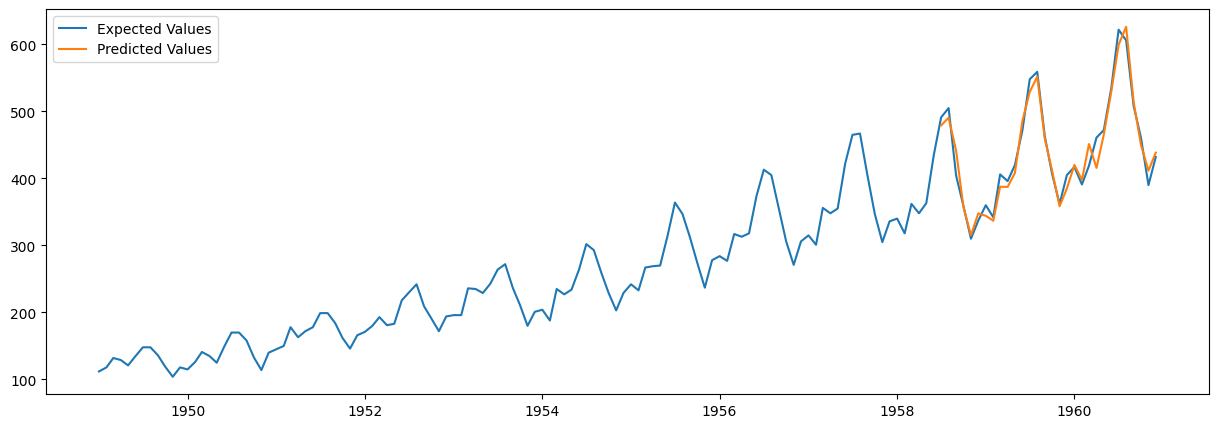

In [115]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [116]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9253


In [117]:
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN,NaN


In [118]:
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[144 + i,3] = f3[i]
forecast.tail()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24773D+00    |proj g|=  3.85280D-02


 This problem is unconstrained.



At iterate    5    f=  3.24330D+00    |proj g|=  3.92157D-02

At iterate   10    f=  3.23721D+00    |proj g|=  1.66594D-02

At iterate   15    f=  3.22917D+00    |proj g|=  4.75928D-03

At iterate   20    f=  3.22880D+00    |proj g|=  1.37446D-03

At iterate   25    f=  3.22866D+00    |proj g|=  3.95146D-04

At iterate   30    f=  3.22865D+00    |proj g|=  1.69603D-04

At iterate   35    f=  3.22864D+00    |proj g|=  3.39559D-05

At iterate   40    f=  3.22864D+00    |proj g|=  1.69853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     45      1     0     0   3.199D-05   3.229D+00
  F =   3.22864379426

 This problem is unconstrained.



At iterate   15    f=  3.22844D+00    |proj g|=  5.05516D-03

At iterate   20    f=  3.22805D+00    |proj g|=  1.50588D-03

At iterate   25    f=  3.22785D+00    |proj g|=  3.93040D-04

At iterate   30    f=  3.22783D+00    |proj g|=  3.49542D-04

At iterate   35    f=  3.22782D+00    |proj g|=  1.14574D-04

At iterate   40    f=  3.22782D+00    |proj g|=  1.04435D-04

At iterate   45    f=  3.22782D+00    |proj g|=  8.75834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     51      1     0     0   8.758D-05   3.228D+00
  F =   3.2278217835897967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.23518D+00    |proj g|=  1.99919D-02

At iterate   15    f=  3.22783D+00    |proj g|=  8.92984D-03

At iterate   20    f=  3.22713D+00    |proj g|=  3.72558D-03

At iterate   25    f=  3.22699D+00    |proj g|=  5.14244D-04

At iterate   30    f=  3.22697D+00    |proj g|=  1.24535D-04

At iterate   35    f=  3.22697D+00    |proj g|=  1.44709D-04

At iterate   40    f=  3.22697D+00    |proj g|=  1.57753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     46      1     0     0   1.023D-04   3.227D+00
  F =   3.2269713418116428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.23965D+00    |proj g|=  3.84420D-02

At iterate   10    f=  3.23513D+00    |proj g|=  1.31385D-02

At iterate   15    f=  3.22703D+00    |proj g|=  6.26990D-03

At iterate   20    f=  3.22639D+00    |proj g|=  6.61841D-03

At iterate   25    f=  3.22613D+00    |proj g|=  6.71783D-04

At iterate   30    f=  3.22610D+00    |proj g|=  5.22484D-04

At iterate   35    f=  3.22610D+00    |proj g|=  4.52202D-04

At iterate   40    f=  3.22609D+00    |proj g|=  1.75846D-04

At iterate   45    f=  3.22609D+00    |proj g|=  3.74309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     53   

 This problem is unconstrained.



At iterate    5    f=  3.23917D+00    |proj g|=  3.73350D-02

At iterate   10    f=  3.23432D+00    |proj g|=  1.75482D-02

At iterate   15    f=  3.22596D+00    |proj g|=  3.44755D-03

At iterate   20    f=  3.22535D+00    |proj g|=  2.21707D-03

At iterate   25    f=  3.22521D+00    |proj g|=  5.08631D-04

At iterate   30    f=  3.22519D+00    |proj g|=  1.59157D-04

At iterate   35    f=  3.22519D+00    |proj g|=  1.41609D-04

At iterate   40    f=  3.22519D+00    |proj g|=  2.01216D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     49      1     0     0   6.501D-06   3.225D+00
  F =   3.22518935565

 This problem is unconstrained.



At iterate    5    f=  3.23893D+00    |proj g|=  3.69248D-02

At iterate   10    f=  3.23340D+00    |proj g|=  1.84012D-02

At iterate   15    f=  3.22507D+00    |proj g|=  5.05481D-03

At iterate   20    f=  3.22463D+00    |proj g|=  2.93224D-03

At iterate   25    f=  3.22428D+00    |proj g|=  9.35003D-04

At iterate   30    f=  3.22426D+00    |proj g|=  2.01188D-04

At iterate   35    f=  3.22426D+00    |proj g|=  4.46279D-05

At iterate   40    f=  3.22426D+00    |proj g|=  8.40851D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     50      1     0     0   1.871D-05   3.224D+00
  F =   3.22426005757

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24313D+00    |proj g|=  3.49581D-02

At iterate    5    f=  3.23826D+00    |proj g|=  3.60779D-02

At iterate   10    f=  3.23304D+00    |proj g|=  9.98140D-03

At iterate   15    f=  3.22434D+00    |proj g|=  5.31742D-03

At iterate   20    f=  3.22356D+00    |proj g|=  1.39403D-03

At iterate   25    f=  3.22336D+00    |proj g|=  4.23534D-04

At iterate   30    f=  3.22331D+00    |proj g|=  1.56050D-04

At iterate   35    f=  3.22331D+00    |proj g|=  3.42874D-04

At iterate   40    f=  3.22331D+00    |proj g|=  8.12478D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.23738D+00    |proj g|=  3.51003D-02

At iterate   10    f=  3.23258D+00    |proj g|=  1.58685D-02

At iterate   15    f=  3.22448D+00    |proj g|=  1.33728D-02

At iterate   20    f=  3.22288D+00    |proj g|=  2.27277D-03

At iterate   25    f=  3.22243D+00    |proj g|=  5.08067D-04

At iterate   30    f=  3.22235D+00    |proj g|=  1.09838D-03

At iterate   35    f=  3.22233D+00    |proj g|=  1.59937D-04

At iterate   40    f=  3.22233D+00    |proj g|=  2.49522D-05

At iterate   45    f=  3.22233D+00    |proj g|=  5.38686D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     54   

 This problem is unconstrained.



At iterate   10    f=  3.23206D+00    |proj g|=  1.83820D-02

At iterate   15    f=  3.22386D+00    |proj g|=  1.34140D-02

At iterate   20    f=  3.22177D+00    |proj g|=  1.83177D-03

At iterate   25    f=  3.22139D+00    |proj g|=  3.21558D-04

At iterate   30    f=  3.22134D+00    |proj g|=  6.33128D-04

At iterate   35    f=  3.22133D+00    |proj g|=  1.57145D-04

At iterate   40    f=  3.22133D+00    |proj g|=  3.99674D-05

At iterate   45    f=  3.22133D+00    |proj g|=  2.75723D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     54      1     0     0   1.004D-04   3.221D+00
  F =   3.22133103144

 This problem is unconstrained.



At iterate    5    f=  3.23591D+00    |proj g|=  3.33931D-02

At iterate   10    f=  3.23149D+00    |proj g|=  1.97996D-02

At iterate   15    f=  3.22331D+00    |proj g|=  1.33936D-02

At iterate   20    f=  3.22083D+00    |proj g|=  2.57817D-03

At iterate   25    f=  3.22039D+00    |proj g|=  1.94703D-03

At iterate   30    f=  3.22032D+00    |proj g|=  7.68993D-04

At iterate   35    f=  3.22031D+00    |proj g|=  1.01945D-04

At iterate   40    f=  3.22031D+00    |proj g|=  6.56676D-05

At iterate   45    f=  3.22031D+00    |proj g|=  2.03924D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     50   

 This problem is unconstrained.



At iterate   10    f=  3.23064D+00    |proj g|=  1.91164D-02

At iterate   15    f=  3.22209D+00    |proj g|=  1.54486D-02

At iterate   20    f=  3.21979D+00    |proj g|=  2.54690D-03

At iterate   25    f=  3.21944D+00    |proj g|=  2.59015D-03

At iterate   30    f=  3.21929D+00    |proj g|=  8.33907D-04

At iterate   35    f=  3.21927D+00    |proj g|=  3.08370D-04

At iterate   40    f=  3.21927D+00    |proj g|=  5.96755D-05

At iterate   45    f=  3.21927D+00    |proj g|=  1.99128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53      1     0     0   2.010D-05   3.219D+00
  F =   3.21926994204

 This problem is unconstrained.



At iterate    5    f=  3.23422D+00    |proj g|=  3.37848D-02

At iterate   10    f=  3.22966D+00    |proj g|=  1.97620D-02

At iterate   15    f=  3.22150D+00    |proj g|=  1.91643D-02

At iterate   20    f=  3.21878D+00    |proj g|=  2.26819D-03

At iterate   25    f=  3.21830D+00    |proj g|=  1.08639D-03

At iterate   30    f=  3.21822D+00    |proj g|=  2.32366D-03

At iterate   35    f=  3.21821D+00    |proj g|=  1.24436D-04

At iterate   40    f=  3.21821D+00    |proj g|=  1.29327D-04

At iterate   45    f=  3.21821D+00    |proj g|=  2.99310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     55   

 This problem is unconstrained.



At iterate   10    f=  3.22856D+00    |proj g|=  2.06713D-02

At iterate   15    f=  3.22090D+00    |proj g|=  1.21641D-02

At iterate   20    f=  3.21799D+00    |proj g|=  3.83930D-03

At iterate   25    f=  3.21722D+00    |proj g|=  3.23686D-03

At iterate   30    f=  3.21714D+00    |proj g|=  7.77803D-04

At iterate   35    f=  3.21713D+00    |proj g|=  1.23530D-04

At iterate   40    f=  3.21713D+00    |proj g|=  2.11808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     51      1     0     0   8.629D-06   3.217D+00
  F =   3.2171300058839063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.23184D+00    |proj g|=  3.03097D-02

At iterate   10    f=  3.22745D+00    |proj g|=  2.21628D-02

At iterate   15    f=  3.21969D+00    |proj g|=  1.20412D-02

At iterate   20    f=  3.21714D+00    |proj g|=  4.31578D-03

At iterate   25    f=  3.21615D+00    |proj g|=  3.77762D-04

At iterate   30    f=  3.21605D+00    |proj g|=  2.15463D-03

At iterate   35    f=  3.21603D+00    |proj g|=  1.77125D-04

At iterate   40    f=  3.21603D+00    |proj g|=  2.95336D-05

At iterate   45    f=  3.21603D+00    |proj g|=  9.78564D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     50   

 This problem is unconstrained.



At iterate    5    f=  3.23079D+00    |proj g|=  2.99775D-02

At iterate   10    f=  3.22637D+00    |proj g|=  2.23135D-02

At iterate   15    f=  3.21862D+00    |proj g|=  1.12182D-02

At iterate   20    f=  3.21606D+00    |proj g|=  4.48119D-03

At iterate   25    f=  3.21504D+00    |proj g|=  1.25951D-03

At iterate   30    f=  3.21494D+00    |proj g|=  1.24679D-03

At iterate   35    f=  3.21492D+00    |proj g|=  2.23668D-04

At iterate   40    f=  3.21492D+00    |proj g|=  5.53305D-05

At iterate   45    f=  3.21492D+00    |proj g|=  5.87737D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     51   

 This problem is unconstrained.



At iterate    5    f=  3.22972D+00    |proj g|=  2.97665D-02

At iterate   10    f=  3.22527D+00    |proj g|=  2.24454D-02

At iterate   15    f=  3.21749D+00    |proj g|=  1.02042D-02

At iterate   20    f=  3.21445D+00    |proj g|=  4.24717D-03

At iterate   25    f=  3.21387D+00    |proj g|=  1.73433D-03

At iterate   30    f=  3.21380D+00    |proj g|=  1.95512D-04

At iterate   35    f=  3.21379D+00    |proj g|=  6.81897D-05

At iterate   40    f=  3.21379D+00    |proj g|=  1.70724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     54      1     0     0   3.136D-05   3.214D+00
  F =   3.21378588170

 This problem is unconstrained.



At iterate    5    f=  3.22863D+00    |proj g|=  2.95683D-02

At iterate   10    f=  3.22415D+00    |proj g|=  2.25496D-02

At iterate   15    f=  3.21633D+00    |proj g|=  8.93799D-03

At iterate   20    f=  3.21380D+00    |proj g|=  4.50460D-03

At iterate   25    f=  3.21279D+00    |proj g|=  2.88815D-03

At iterate   30    f=  3.21266D+00    |proj g|=  3.12480D-04

At iterate   35    f=  3.21264D+00    |proj g|=  4.78378D-04

At iterate   40    f=  3.21264D+00    |proj g|=  1.09809D-04

At iterate   45    f=  3.21264D+00    |proj g|=  7.57092D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     49   

 This problem is unconstrained.



At iterate    5    f=  3.22752D+00    |proj g|=  2.93803D-02

At iterate   10    f=  3.22301D+00    |proj g|=  2.26314D-02

At iterate   15    f=  3.21515D+00    |proj g|=  7.44746D-03

At iterate   20    f=  3.21259D+00    |proj g|=  4.18372D-03

At iterate   25    f=  3.21159D+00    |proj g|=  1.16925D-03

At iterate   30    f=  3.21149D+00    |proj g|=  2.56790D-03

At iterate   35    f=  3.21148D+00    |proj g|=  5.56656D-04

At iterate   40    f=  3.21148D+00    |proj g|=  6.38405D-05

At iterate   45    f=  3.21148D+00    |proj g|=  4.86988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23089D+00    |proj g|=  3.36583D-02

At iterate    5    f=  3.22640D+00    |proj g|=  2.92457D-02

At iterate   10    f=  3.22187D+00    |proj g|=  2.26928D-02

At iterate   15    f=  3.21397D+00    |proj g|=  5.88643D-03

At iterate   20    f=  3.21130D+00    |proj g|=  3.57526D-03

At iterate   25    f=  3.21043D+00    |proj g|=  3.53912D-03

At iterate   30    f=  3.21031D+00    |proj g|=  3.84573D-04

At iterate   35    f=  3.21030D+00    |proj g|=  2.42229D-04

At iterate   40    f=  3.21030D+00    |proj g|=  1.35571D-04

At iterate   45    f=  3.21030D+00    |proj g|=  7.06356D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.22527D+00    |proj g|=  2.92393D-02

At iterate   10    f=  3.22071D+00    |proj g|=  2.27386D-02

At iterate   15    f=  3.21279D+00    |proj g|=  4.94790D-03

At iterate   20    f=  3.21007D+00    |proj g|=  4.05482D-03

At iterate   25    f=  3.20921D+00    |proj g|=  1.05471D-03

At iterate   30    f=  3.20913D+00    |proj g|=  2.59085D-03

At iterate   35    f=  3.20911D+00    |proj g|=  1.05134D-03

At iterate   40    f=  3.20911D+00    |proj g|=  8.73167D-05

At iterate   45    f=  3.20911D+00    |proj g|=  4.05131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     54   

 This problem is unconstrained.



At iterate   15    f=  3.21180D+00    |proj g|=  1.11638D-02

At iterate   20    f=  3.20839D+00    |proj g|=  5.09538D-03

At iterate   25    f=  3.20796D+00    |proj g|=  3.20165D-04

At iterate   30    f=  3.20791D+00    |proj g|=  6.86283D-04

At iterate   35    f=  3.20790D+00    |proj g|=  1.22792D-04

At iterate   40    f=  3.20790D+00    |proj g|=  5.92027D-05

At iterate   45    f=  3.20790D+00    |proj g|=  2.36485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     56      1     0     0   8.979D-05   3.208D+00
  F =   3.2078998976482160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.22287D+00    |proj g|=  2.78453D-02

At iterate   10    f=  3.21825D+00    |proj g|=  2.27645D-02

At iterate   15    f=  3.21130D+00    |proj g|=  9.18044D-03

At iterate   20    f=  3.20785D+00    |proj g|=  5.71857D-03

At iterate   25    f=  3.20679D+00    |proj g|=  9.56915D-04

At iterate   30    f=  3.20670D+00    |proj g|=  5.29408D-04

At iterate   35    f=  3.20668D+00    |proj g|=  2.73509D-04

At iterate   40    f=  3.20668D+00    |proj g|=  1.49822D-04

At iterate   45    f=  3.20668D+00    |proj g|=  6.81710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     51   

 This problem is unconstrained.



At iterate    5    f=  3.22165D+00    |proj g|=  2.71750D-02

At iterate   10    f=  3.21696D+00    |proj g|=  2.27087D-02

At iterate   15    f=  3.20997D+00    |proj g|=  1.90079D-02

At iterate   20    f=  3.20613D+00    |proj g|=  4.11847D-03

At iterate   25    f=  3.20551D+00    |proj g|=  1.16265D-03

At iterate   30    f=  3.20546D+00    |proj g|=  1.96218D-04

At iterate   35    f=  3.20545D+00    |proj g|=  1.31636D-04

At iterate   40    f=  3.20545D+00    |proj g|=  4.03631D-05

At iterate   45    f=  3.20545D+00    |proj g|=  2.70966D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53   

 This problem is unconstrained.



At iterate   10    f=  3.21568D+00    |proj g|=  2.26611D-02

At iterate   15    f=  3.20837D+00    |proj g|=  8.12692D-03

At iterate   20    f=  3.20539D+00    |proj g|=  3.29932D-02

At iterate   25    f=  3.20429D+00    |proj g|=  1.11381D-03

At iterate   30    f=  3.20422D+00    |proj g|=  5.61473D-04

At iterate   35    f=  3.20421D+00    |proj g|=  6.55418D-05

At iterate   40    f=  3.20421D+00    |proj g|=  9.91678D-05

At iterate   45    f=  3.20421D+00    |proj g|=  2.06501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     55      1     0     0   1.170D-05   3.204D+00
  F =   3.20420764981

 This problem is unconstrained.



At iterate    5    f=  3.21923D+00    |proj g|=  2.65809D-02

At iterate   10    f=  3.21441D+00    |proj g|=  2.26142D-02

At iterate   15    f=  3.20738D+00    |proj g|=  5.60628D-03

At iterate   20    f=  3.20391D+00    |proj g|=  1.46221D-02

At iterate   25    f=  3.20303D+00    |proj g|=  4.83158D-04

At iterate   30    f=  3.20296D+00    |proj g|=  4.44634D-04

At iterate   35    f=  3.20296D+00    |proj g|=  2.31467D-04

At iterate   40    f=  3.20295D+00    |proj g|=  7.21554D-05

At iterate   45    f=  3.20295D+00    |proj g|=  2.85051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     55   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22260D+00    |proj g|=  3.37840D-02

At iterate    5    f=  3.21793D+00    |proj g|=  2.52501D-02

At iterate   10    f=  3.21265D+00    |proj g|=  2.17912D-02

At iterate   15    f=  3.20343D+00    |proj g|=  1.35580D-02

At iterate   20    f=  3.20225D+00    |proj g|=  5.21546D-03

At iterate   25    f=  3.20174D+00    |proj g|=  4.27286D-04

At iterate   30    f=  3.20170D+00    |proj g|=  3.64206D-04

At iterate   35    f=  3.20169D+00    |proj g|=  3.12676D-04

At iterate   40    f=  3.20169D+00    |proj g|=  3.64630D-05

At iterate   45    f=  3.20169D+00    |proj g|=  2.89510D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.21670D+00    |proj g|=  2.50686D-02

At iterate   10    f=  3.21131D+00    |proj g|=  2.14995D-02

At iterate   15    f=  3.20320D+00    |proj g|=  1.51586D-02

At iterate   20    f=  3.20073D+00    |proj g|=  1.35419D-02

At iterate   25    f=  3.20048D+00    |proj g|=  2.59632D-03

At iterate   30    f=  3.20042D+00    |proj g|=  3.06313D-04

At iterate   35    f=  3.20041D+00    |proj g|=  4.22935D-05

At iterate   40    f=  3.20041D+00    |proj g|=  6.60155D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     53      1     0     0   1.556D-05   3.200D+00
  F =   3.20041240507

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22013D+00    |proj g|=  3.38431D-02

At iterate    5    f=  3.21546D+00    |proj g|=  2.48928D-02

At iterate   10    f=  3.20995D+00    |proj g|=  2.11318D-02

At iterate   15    f=  3.20146D+00    |proj g|=  9.72199D-03

At iterate   20    f=  3.19984D+00    |proj g|=  6.29743D-03

At iterate   25    f=  3.19920D+00    |proj g|=  2.06018D-03

At iterate   30    f=  3.19914D+00    |proj g|=  6.23803D-04

At iterate   35    f=  3.19913D+00    |proj g|=  2.31453D-04

At iterate   40    f=  3.19913D+00    |proj g|=  1.32334D-04

At iterate   45    f=  3.19913D+00    |proj g|=  9.85848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   10    f=  3.20860D+00    |proj g|=  2.07607D-02

At iterate   15    f=  3.20019D+00    |proj g|=  1.16040D-02

At iterate   20    f=  3.19838D+00    |proj g|=  2.46649D-03

At iterate   25    f=  3.19794D+00    |proj g|=  3.12500D-03

At iterate   30    f=  3.19784D+00    |proj g|=  3.74747D-04

At iterate   35    f=  3.19783D+00    |proj g|=  1.01117D-04

At iterate   40    f=  3.19783D+00    |proj g|=  4.03996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     51      1     0     0   6.960D-06   3.198D+00
  F =   3.1978312849323833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.21295D+00    |proj g|=  2.45677D-02

At iterate   10    f=  3.20721D+00    |proj g|=  2.01543D-02

At iterate   15    f=  3.19839D+00    |proj g|=  1.17970D-02

At iterate   20    f=  3.19706D+00    |proj g|=  5.21943D-03

At iterate   25    f=  3.19657D+00    |proj g|=  1.22471D-03

At iterate   30    f=  3.19653D+00    |proj g|=  2.77019D-04

At iterate   35    f=  3.19653D+00    |proj g|=  1.08757D-04

At iterate   40    f=  3.19653D+00    |proj g|=  1.99386D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     50      1     0     0   6.164D-05   3.197D+00
  F =   3.19652667741

 This problem is unconstrained.



At iterate   10    f=  3.20585D+00    |proj g|=  1.96713D-02

At iterate   15    f=  3.19788D+00    |proj g|=  2.44540D-02

At iterate   20    f=  3.19604D+00    |proj g|=  5.60951D-03

At iterate   25    f=  3.19529D+00    |proj g|=  1.06993D-03

At iterate   30    f=  3.19523D+00    |proj g|=  3.40098D-04

At iterate   35    f=  3.19522D+00    |proj g|=  2.50284D-04

At iterate   40    f=  3.19521D+00    |proj g|=  5.40560D-05

At iterate   45    f=  3.19521D+00    |proj g|=  2.02390D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     53      1     0     0   2.024D-04   3.195D+00
  F =   3.19521336686

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21506D+00    |proj g|=  3.39498D-02

At iterate    5    f=  3.21038D+00    |proj g|=  2.38613D-02

At iterate   10    f=  3.20409D+00    |proj g|=  1.49984D-02

At iterate   15    f=  3.19585D+00    |proj g|=  8.36721D-03

At iterate   20    f=  3.19416D+00    |proj g|=  2.07111D-03

At iterate   25    f=  3.19394D+00    |proj g|=  4.08958D-03

At iterate   30    f=  3.19390D+00    |proj g|=  7.40349D-04

At iterate   35    f=  3.19389D+00    |proj g|=  8.90084D-05

At iterate   40    f=  3.19389D+00    |proj g|=  1.37081D-05

At iterate   45    f=  3.19389D+00    |proj g|=  5.28564D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.20906D+00    |proj g|=  2.31732D-02

At iterate   10    f=  3.20248D+00    |proj g|=  8.29930D-03

At iterate   15    f=  3.19412D+00    |proj g|=  1.23537D-02

At iterate   20    f=  3.19299D+00    |proj g|=  5.89253D-03

At iterate   25    f=  3.19260D+00    |proj g|=  2.40858D-03

At iterate   30    f=  3.19257D+00    |proj g|=  1.55127D-04

At iterate   35    f=  3.19256D+00    |proj g|=  1.23855D-04

At iterate   40    f=  3.19256D+00    |proj g|=  6.80125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     48      1     0     0   8.287D-05   3.193D+00
  F =   3.19256177576

 This problem is unconstrained.



At iterate    5    f=  3.20774D+00    |proj g|=  2.26990D-02

At iterate   10    f=  3.20126D+00    |proj g|=  9.86883D-03

At iterate   15    f=  3.19302D+00    |proj g|=  6.40203D-03

At iterate   20    f=  3.19176D+00    |proj g|=  8.91857D-03

At iterate   25    f=  3.19127D+00    |proj g|=  8.00172D-04

At iterate   30    f=  3.19123D+00    |proj g|=  7.85504D-04

At iterate   35    f=  3.19122D+00    |proj g|=  6.35629D-05

At iterate   40    f=  3.19122D+00    |proj g|=  4.87062D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     54      1     0     0   3.142D-05   3.191D+00
  F =   3.19122432940

 This problem is unconstrained.



At iterate    5    f=  3.20644D+00    |proj g|=  2.25633D-02

At iterate   10    f=  3.20001D+00    |proj g|=  1.03848D-02

At iterate   15    f=  3.19154D+00    |proj g|=  1.80830D-02

At iterate   20    f=  3.19054D+00    |proj g|=  3.06011D-03

At iterate   25    f=  3.18996D+00    |proj g|=  1.00315D-03

At iterate   30    f=  3.18989D+00    |proj g|=  1.96010D-03

At iterate   35    f=  3.18988D+00    |proj g|=  5.66212D-05

At iterate   40    f=  3.18988D+00    |proj g|=  2.41476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     52      1     0     0   2.415D-05   3.190D+00
  F =   3.18987953041

 This problem is unconstrained.



At iterate    5    f=  3.20513D+00    |proj g|=  2.24329D-02

At iterate   10    f=  3.19875D+00    |proj g|=  1.08733D-02

At iterate   15    f=  3.18998D+00    |proj g|=  9.74296D-03

At iterate   20    f=  3.18915D+00    |proj g|=  3.62048D-03

At iterate   25    f=  3.18862D+00    |proj g|=  3.25589D-04

At iterate   30    f=  3.18854D+00    |proj g|=  6.53419D-04

At iterate   35    f=  3.18853D+00    |proj g|=  5.34052D-04

At iterate   40    f=  3.18853D+00    |proj g|=  2.24289D-05

At iterate   45    f=  3.18853D+00    |proj g|=  9.40072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     57   

 This problem is unconstrained.



At iterate    5    f=  3.20382D+00    |proj g|=  2.22937D-02

At iterate   10    f=  3.19749D+00    |proj g|=  1.12123D-02

At iterate   15    f=  3.18856D+00    |proj g|=  7.60206D-03

At iterate   20    f=  3.18778D+00    |proj g|=  1.46353D-02

At iterate   25    f=  3.18724D+00    |proj g|=  1.02493D-03

At iterate   30    f=  3.18718D+00    |proj g|=  2.54924D-04

At iterate   35    f=  3.18717D+00    |proj g|=  1.96121D-04

At iterate   40    f=  3.18717D+00    |proj g|=  4.32018D-05

At iterate   45    f=  3.18717D+00    |proj g|=  4.00279D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     52   

 This problem is unconstrained.



At iterate   10    f=  3.19623D+00    |proj g|=  1.15059D-02

At iterate   15    f=  3.18717D+00    |proj g|=  1.00324D-02

At iterate   20    f=  3.18651D+00    |proj g|=  1.21978D-02

At iterate   25    f=  3.18588D+00    |proj g|=  5.05166D-04

At iterate   30    f=  3.18582D+00    |proj g|=  1.33599D-03

At iterate   35    f=  3.18581D+00    |proj g|=  1.50130D-04

At iterate   40    f=  3.18580D+00    |proj g|=  1.18057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     52      1     0     0   1.514D-05   3.186D+00
  F =   3.1858045729469904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.20116D+00    |proj g|=  2.19769D-02

At iterate   10    f=  3.19495D+00    |proj g|=  1.16121D-02

At iterate   15    f=  3.18596D+00    |proj g|=  1.20334D-02

At iterate   20    f=  3.18517D+00    |proj g|=  8.25323D-03

At iterate   25    f=  3.18449D+00    |proj g|=  1.12344D-03

At iterate   30    f=  3.18444D+00    |proj g|=  6.78831D-04

At iterate   35    f=  3.18444D+00    |proj g|=  3.04863D-04

At iterate   40    f=  3.18443D+00    |proj g|=  3.71304D-05

At iterate   45    f=  3.18443D+00    |proj g|=  9.83821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20456D+00    |proj g|=  3.41485D-02

At iterate    5    f=  3.19983D+00    |proj g|=  2.18495D-02

At iterate   10    f=  3.19365D+00    |proj g|=  1.16671D-02

At iterate   15    f=  3.18471D+00    |proj g|=  1.27121D-02

At iterate   20    f=  3.18379D+00    |proj g|=  8.15975D-03

At iterate   25    f=  3.18313D+00    |proj g|=  2.39800D-03

At iterate   30    f=  3.18307D+00    |proj g|=  7.95427D-04

At iterate   35    f=  3.18306D+00    |proj g|=  1.89702D-04

At iterate   40    f=  3.18306D+00    |proj g|=  7.37785D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.19849D+00    |proj g|=  2.17225D-02

At iterate   10    f=  3.19233D+00    |proj g|=  1.17003D-02

At iterate   15    f=  3.18340D+00    |proj g|=  1.31516D-02

At iterate   20    f=  3.18242D+00    |proj g|=  1.22181D-02

At iterate   25    f=  3.18174D+00    |proj g|=  2.64399D-03

At iterate   30    f=  3.18168D+00    |proj g|=  4.47627D-04

At iterate   35    f=  3.18168D+00    |proj g|=  3.05614D-04

At iterate   40    f=  3.18168D+00    |proj g|=  5.28505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     50      1     0     0   1.268D-04   3.182D+00
  F =   3.18167512334

 This problem is unconstrained.



At iterate    5    f=  3.19714D+00    |proj g|=  2.15932D-02

At iterate   10    f=  3.19101D+00    |proj g|=  1.17221D-02

At iterate   15    f=  3.18204D+00    |proj g|=  1.32693D-02

At iterate   20    f=  3.18106D+00    |proj g|=  1.72295D-02

At iterate   25    f=  3.18035D+00    |proj g|=  1.40433D-03

At iterate   30    f=  3.18030D+00    |proj g|=  8.11685D-04

At iterate   35    f=  3.18029D+00    |proj g|=  7.17770D-05

At iterate   40    f=  3.18029D+00    |proj g|=  3.74285D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     53      1     0     0   9.351D-06   3.180D+00
  F =   3.18028785519

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20052D+00    |proj g|=  3.42258D-02

At iterate    5    f=  3.19579D+00    |proj g|=  2.14687D-02

At iterate   10    f=  3.18968D+00    |proj g|=  1.17348D-02

At iterate   15    f=  3.18065D+00    |proj g|=  1.32461D-02

At iterate   20    f=  3.17968D+00    |proj g|=  1.76489D-02

At iterate   25    f=  3.17895D+00    |proj g|=  3.90053D-04

At iterate   30    f=  3.17891D+00    |proj g|=  4.30732D-04

At iterate   35    f=  3.17890D+00    |proj g|=  3.18252D-04

At iterate   40    f=  3.17890D+00    |proj g|=  2.20181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.19444D+00    |proj g|=  2.13442D-02

At iterate   10    f=  3.18834D+00    |proj g|=  1.17412D-02

At iterate   15    f=  3.17924D+00    |proj g|=  1.31607D-02

At iterate   20    f=  3.17828D+00    |proj g|=  1.51577D-02

At iterate   25    f=  3.17755D+00    |proj g|=  3.63524D-04

At iterate   30    f=  3.17751D+00    |proj g|=  1.28789D-03

At iterate   35    f=  3.17750D+00    |proj g|=  1.02805D-04

At iterate   40    f=  3.17750D+00    |proj g|=  1.12836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     53      1     0     0   8.858D-06   3.177D+00
  F =   3.17749879502

 This problem is unconstrained.



At iterate    5    f=  3.19308D+00    |proj g|=  2.12210D-02

At iterate   10    f=  3.18700D+00    |proj g|=  1.17422D-02

At iterate   15    f=  3.17783D+00    |proj g|=  1.30500D-02

At iterate   20    f=  3.17690D+00    |proj g|=  1.49639D-02

At iterate   25    f=  3.17616D+00    |proj g|=  2.46309D-04

At iterate   30    f=  3.17611D+00    |proj g|=  2.35367D-03

At iterate   35    f=  3.17610D+00    |proj g|=  7.11117D-04

At iterate   40    f=  3.17610D+00    |proj g|=  6.02736D-05

At iterate   45    f=  3.17610D+00    |proj g|=  6.40998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     58   

 This problem is unconstrained.



At iterate    5    f=  3.19171D+00    |proj g|=  2.10989D-02

At iterate   10    f=  3.18565D+00    |proj g|=  1.17377D-02

At iterate   15    f=  3.17642D+00    |proj g|=  1.29451D-02

At iterate   20    f=  3.17554D+00    |proj g|=  1.80643D-02

At iterate   25    f=  3.17478D+00    |proj g|=  2.97302D-04

At iterate   30    f=  3.17470D+00    |proj g|=  4.01583D-04

At iterate   35    f=  3.17469D+00    |proj g|=  1.87794D-04

At iterate   40    f=  3.17469D+00    |proj g|=  9.38229D-05

At iterate   45    f=  3.17469D+00    |proj g|=  1.85237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     61   

 This problem is unconstrained.



At iterate    5    f=  3.19034D+00    |proj g|=  2.09795D-02

At iterate   10    f=  3.18429D+00    |proj g|=  1.17284D-02

At iterate   15    f=  3.17501D+00    |proj g|=  1.28419D-02

At iterate   20    f=  3.17421D+00    |proj g|=  2.23560D-02

At iterate   25    f=  3.17339D+00    |proj g|=  4.38581D-04

At iterate   30    f=  3.17330D+00    |proj g|=  3.57897D-04

At iterate   35    f=  3.17328D+00    |proj g|=  1.61625D-04

At iterate   40    f=  3.17328D+00    |proj g|=  7.38551D-05

At iterate   45    f=  3.17328D+00    |proj g|=  1.82638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     54   

 This problem is unconstrained.



At iterate    5    f=  3.18897D+00    |proj g|=  2.08604D-02

At iterate   10    f=  3.18293D+00    |proj g|=  1.17155D-02

At iterate   15    f=  3.17359D+00    |proj g|=  1.27132D-02

At iterate   20    f=  3.17272D+00    |proj g|=  1.03587D-02

At iterate   25    f=  3.17195D+00    |proj g|=  2.54854D-04

At iterate   30    f=  3.17188D+00    |proj g|=  4.69558D-04

At iterate   35    f=  3.17187D+00    |proj g|=  2.39248D-04

At iterate   40    f=  3.17187D+00    |proj g|=  1.10707D-04

At iterate   45    f=  3.17187D+00    |proj g|=  1.53086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     58   

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,388.71,388.71,423.79,NaN
1961-10-12,NaN,388.71,388.71,469.38,NaN
1961-10-19,NaN,388.71,388.71,456.60,NaN
1961-10-26,NaN,388.71,388.71,471.07,NaN
1961-11-02,NaN,388.71,388.71,542.69,NaN


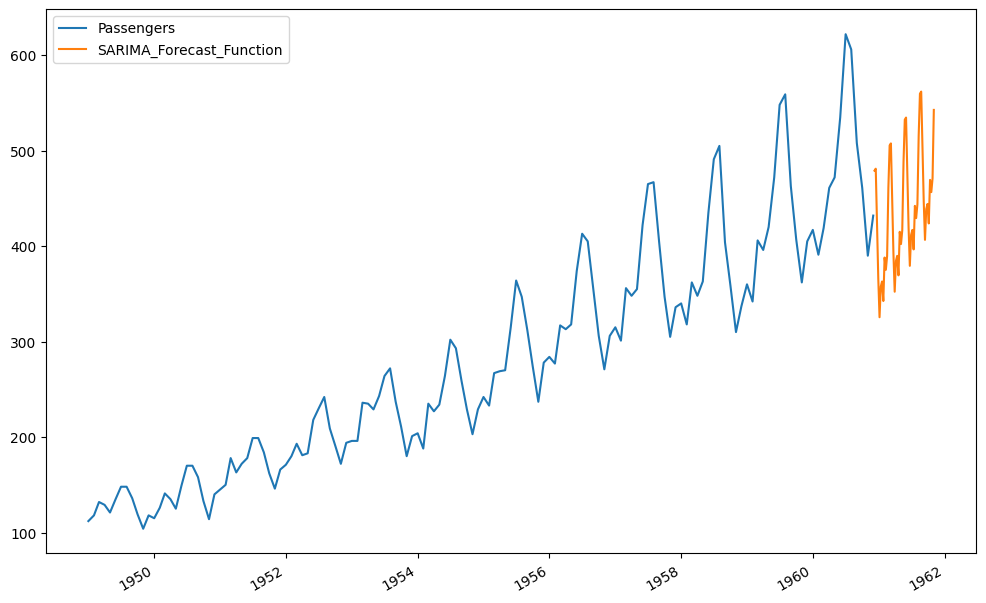

In [119]:
forecast[['Passengers','SARIMA_Forecast_Function']].plot(figsize = (12,8));
